# SqueezeNet for Mars/Earth Classification

- Build model on mobile (or smaller variation of a image classifier) so can predict easily on hosted platform
- Need dockerize model [Accepts an image as input & returns a Prediction = (earth or mars) as output]

In [ ]:
# Load in SqueezeNet 
import torch


#model = torch.hub.load('huawei-noah/ghostnet', 'ghostnet_1x', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True) #switched to SqueezeNet (issues w GhostNet, not right kind of img model & less params)

model.train() 
model.eval()

In [27]:
# Imports + Custom Dataset 

import os
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode

from PlanetaryImages import * #Custom Built Dataset
from ImageClassifierUtils import * #Custom Utilities


In [ ]:
next(iter(dataloaders["train"]))

In [3]:
# Test Instantiation

model_name = "squeezenet"
num_classes = 2 #num output classes
feature_extract = False #if True, proceed with Feature-Extraction | else Fine-Tune


# Load in Model & change output layer
#model = models.resnet18(pretrained=True)
model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True) #switched to SqueezeNet (issues w GhostNet, not right kind of img model & less params)


set_parameter_requires_grad(model, feature_extract)

#output_features = model.fc.in_features #512 in our case -- layer before output! 
#output_features = model.fc.in_features
#model.fc = nn.Linear(output_features, num_classes) 
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1)) #squeezenet specific changes

# 512 is Layer for SqueezeNet
#correct output layer for GhostNet is 1280 is from 1st half of output layer (found visually after loading in)


# Training Parameters -- Decided on these hyperparams after testing
num_epochs = 1 #due to GPU constraints
learning_rate = .001 #best param
momentum = .9 #for SGD


# Use GPU if Possible
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True #input size is fixed, so optimize for it
model_ft = model.to(device) #Send the model to GPU


# Define which params to update (depending on if Feature-Extracting or Fine-Tune)
params_to_update = model_ft.parameters()
params_to_learn(feature_extract, model_ft, params_to_update) #in function sectino


# Optimizers
optimizer_ft = optim.SGD(params_to_update, lr=learning_rate, momentum=momentum) #main version
#optimizer_ft = optim.Adam(params_to_update, lr=learning_rate)


# Loss Function
criterion = nn.CrossEntropyLoss()

Using cache found in /home/ckg/.cache/torch/hub/pytorch_vision_v0.10.0


Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.squeeze.weight
	 features.3.squeeze.bias
	 features.3.expand1x1.weight
	 features.3.expand1x1.bias
	 features.3.expand3x3.weight
	 features.3.expand3x3.bias
	 features.4.squeeze.weight
	 features.4.squeeze.bias
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features.8.squeeze.bias
	 features.8.expand1x1.weight
	 features.8.expand1x1.bias
	 features.8.expand3x3.weight
	 features.8.expand3x3.bias
	 features.9.squeeze.weight
	 features.9.squeeze.bias
	 features.9.expand1x1.weight
	 features.

In [13]:
# Train Model for a Few Epochs 
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=10)


Epoch 1 of 10
-------------
train Loss: 0.0127 | Accuracy: 0.9949
test Loss: 0.0071 | Accuracy: 0.9989

Epoch 2 of 10
-------------
train Loss: 0.0107 | Accuracy: 0.9971
test Loss: 0.0057 | Accuracy: 0.9977

Epoch 3 of 10
-------------
train Loss: 0.0021 | Accuracy: 0.9995
test Loss: 0.0004 | Accuracy: 1.0000

Epoch 4 of 10
-------------
train Loss: 0.0049 | Accuracy: 0.9980
test Loss: 0.0009 | Accuracy: 1.0000

Epoch 5 of 10
-------------
train Loss: 0.0076 | Accuracy: 0.9975
test Loss: 0.0079 | Accuracy: 0.9966

Epoch 6 of 10
-------------
train Loss: 0.0057 | Accuracy: 0.9980
test Loss: 0.0020 | Accuracy: 1.0000

Epoch 7 of 10
-------------
train Loss: 0.0036 | Accuracy: 0.9989
test Loss: 0.0025 | Accuracy: 0.9989

Epoch 8 of 10
-------------
train Loss: 0.0016 | Accuracy: 0.9997
test Loss: 0.0036 | Accuracy: 0.9989

Epoch 9 of 10
-------------
train Loss: 0.0033 | Accuracy: 0.9988
test Loss: 0.0002 | Accuracy: 1.0000

Epoch 10 of 10
--------------
train Loss: 0.0017 | Accuracy: 0.9

In [30]:
# Save Trained Model
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

torch.save(model.state_dict(), "../DockerImage/Model/EM-NET-WEIGHTS.pkl")


# Saved as Recommended in this Repo- https://github.com/pytorch/serve/tree/master/examples/image_classifier/squeezenet
#ideal for inference?
sm = torch.jit.script(model)
sm.save("../DockerImage/Model/EM-NET.pt")


In [18]:
type(model)


torchvision.models.squeezenet.SqueezeNet

In [29]:
# Load a Saved Model & Predict

m1 = torchvision.models.squeezenet.SqueezeNet()
m1.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1)) #squeezenet specific changes - IMPORTANT
m1.load_state_dict(torch.load("../DockerImage/P-Net.pkl"))
m1.eval()

# Try Eval
# Move to GPU if Available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    m1.to('cuda')

with torch.no_grad(): #not updating weights in misc pred test
    output = m1(input_batch)

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0) #scaled down output
print(probabilities)

tensor([1.7452e-06, 1.0000e+00], device='cuda:0')


In [48]:
pred = probabilities[1] #probability of Mars
a.item()
if pred >= 0.5: 
    label = "mars"
elif pred < 0.5: 
    label = "earth"

print(label)

mars


In [47]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms

# Open Image

input_image = Image.open('../PlanetaryImages/0503MH0002990020200594I01_DRCL.JPG') #random mars image

# Earth Images
#00000041_(3).jpg
#00000041_(5).jpg

# Mars Images
#0647MH0003250050203806E01_DRCL.JPG
#0503MH0002990020200594I01_DRCL.JPG
#0869MH0002970020302266I01_DRCL.JPG

# PreProcessing Pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224), #maybe do random crops of Mars images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #heuristic transforms (widely used & gtg)
])


input_tensor = preprocess(input_image)
input_tensor = transform(input_image) #defined in PlanetaryImages import
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model


# Move to GPU if Available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad(): #not updating weights in misc pred test
    output = model(input_batch)

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0) #scaled down output
print(probabilities)

tensor([2.2105e-05, 9.9998e-01], device='cuda:0')


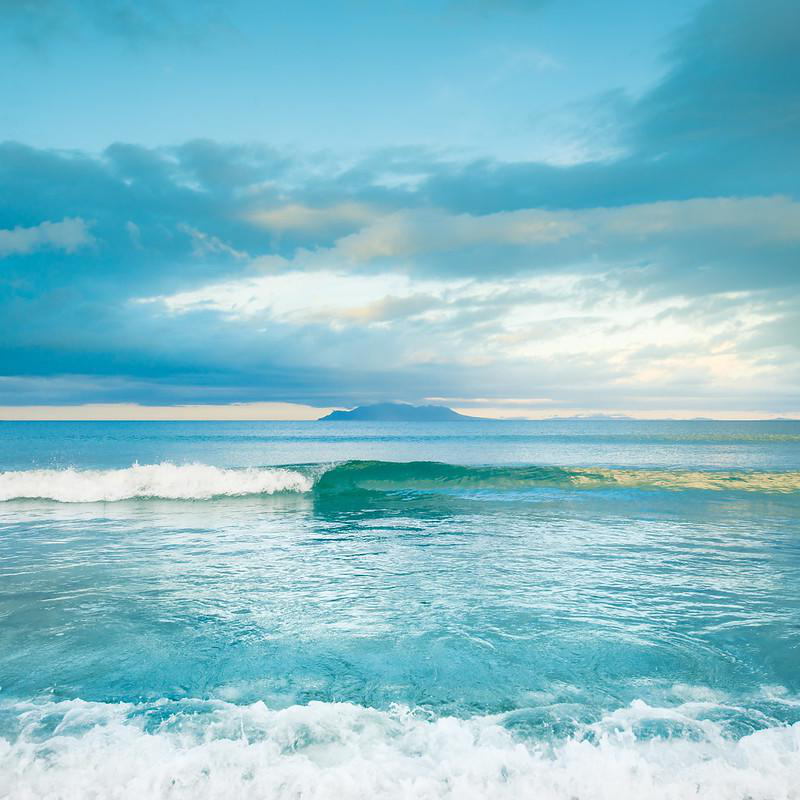

In [12]:
input_image #100% (rounded) to be an Earth Image!

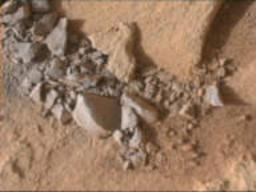

In [25]:
input_image #100% (rounded) estimated to be a Mars Image!

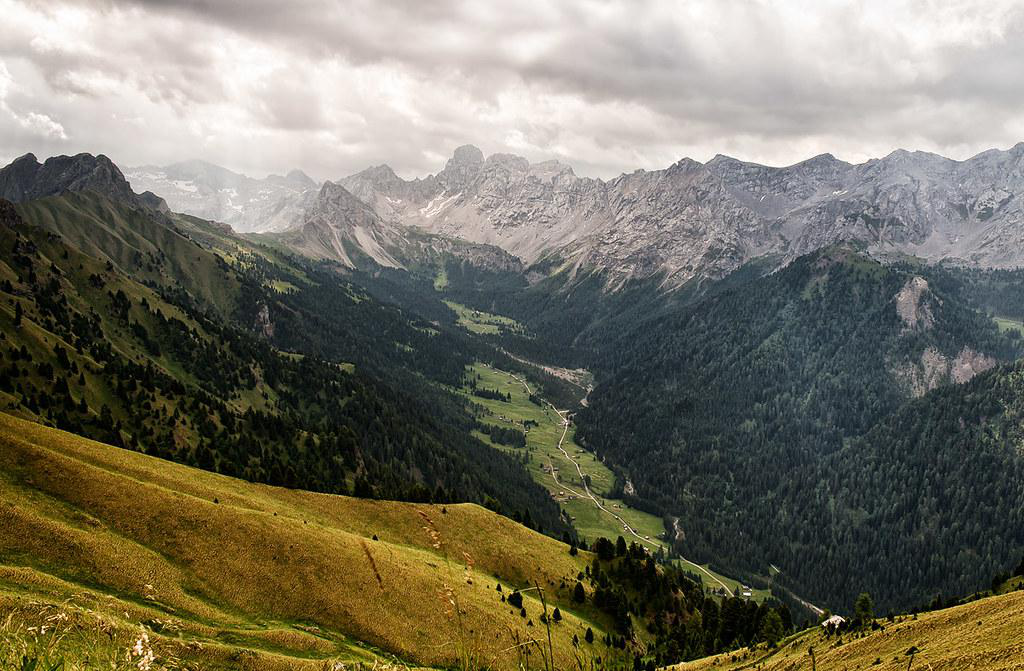

In [10]:
input_image #100% (rounded) to be an Earth Image!

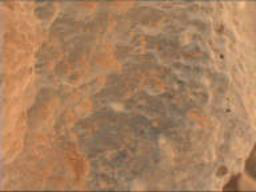

In [7]:
input_image #0.99982 likely to be a mars image

In [14]:
output.shape

torch.Size([1, 1000])

goldfish 0.9999020099639893
tench 5.343230805010535e-05
leafhopper 3.266695102865924e-06
fiddler crab 2.0489417238422902e-06
toucan 1.540244397801871e-06


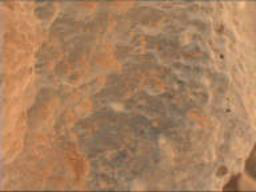

In [10]:
# Check probabilities against Labels


# Get Labels (categories = cats)
with open("../imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

t5_probs, t5_catid = torch.topk(probabilities, k=5)

for i in range(t5_probs.size(0)):
    print(categories[t5_catid[i]], t5_probs[i].item())


input_image #PIL lib provided (Open_Image)



In [49]:
pytorch_total_params = sum(p.numel() for p in model.parameters())

pytorch_total_params #5,122,508 for GhostNet
#736,450 for SqueezeNet

736450